# Алутис Никита группа 207

In [ ]:
import os
import json
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.optimizers import Adam
import keras
from keras.models import Model
from tensorflow.keras.layers import Input,Flatten, Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation
import tensorflow.keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, concatenate,Conv2DTranspose
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, BatchNormalization
from skimage.transform import resize
from skimage.io import imsave
from keras.callbacks import ModelCheckpoint
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices
smooth = 1.

In [3]:
"""
Load training data into images and labels lists

images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
labels list consists of ground truth masks -  numpy arrays of shape (512, 512, n_slices), where:
    0 - background class
    1 - regions of consolidation class
"""

path = './data/' # Replace this line with path to data directory
path_images = os.path.join(path, 'images')
path_labels = os.path.join(path, 'labels')
with open('training_data.json', 'r') as f:
    dict_training = json.load(f)

images = []
labels = []
for entry in tqdm(dict_training):
    image = nib.load(os.path.join(path_images, entry['image']))
    label = nib.load(os.path.join(path_labels, entry['label']))
    images.append(image.get_fdata())
    labels.append(label.get_fdata())

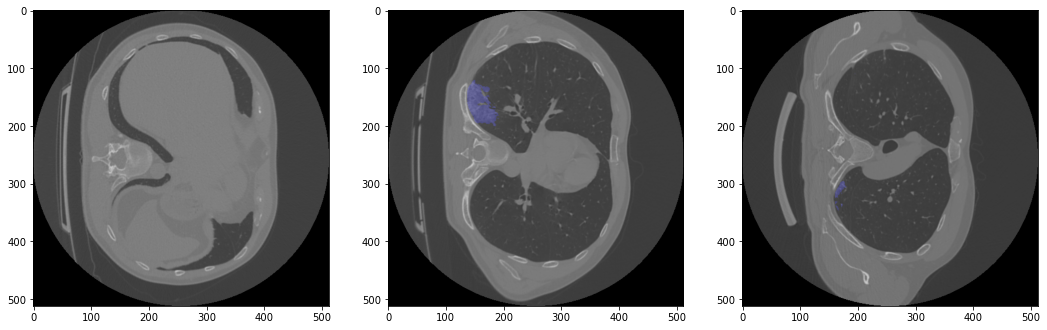

In [4]:
#Visualize some of the slices
from PIL import Image
import matplotlib.pyplot as plt

def blend(image, mask):
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

patient_num = 15
slices_num = (10, 20, 30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images[patient_num][..., idx],
        labels[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [5]:
def to_np_line(comp_img):
    imgs = []
    for i in range(len(comp_img)):
        for k in range(comp_img[i].shape[2]):
            imgs.append(comp_img[i][:,:,k])
    return np.array(imgs,dtype='float32')

def preprocess(imgs):
    imgs_p = imgs.astype('float32')
    mean = np.mean(imgs_p)
    std = np.std(imgs_p)
    imgs_p -= mean
    imgs_p /= std
    return imgs_p

In [6]:
x_train = to_np_line(images)
y_train = to_np_line(labels)
del images
del labels
del slices

In [7]:
x_train_p = []
for i in range(len(x_train)):
    x_train_p.append((x_train[i] - np.mean(x_train[i])) / np.std(x_train[i]))
del x_train
x_train_p = np.array(x_train_p, dtype = 'float32')
y_train = np.array(y_train, dtype = 'float32')

In [8]:
def dice(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

    
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)


def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y


def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def dice_weighted_loss(y_true, y_pred):
    return -dice_weighted(y_true, y_pred)

def weighted_binary_crossentropy(y_true, y_pred):
    zero_weight = 1
    one_weight = 4
    b_ce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce
    return K.mean(weighted_b_ce)



# Основная модель ( карты весов временно убраны из loss, проблемы с компиляцией модели при них) - скор 0.62+

# Фит с картой весов дальше в блокноте находится
# ВАЖНО! количество эпох на данный момент подобрано не оптимально скорее всего, надо править. На 30 эпохах достигался score 0.63 без карт весов

In [50]:
def att_gate(filters, x, g):
    x = UpSampling2D((2,2))(x)
    theta_x = Conv2D(filters, (1, 1), strides=(1, 1), kernel_initializer="he_uniform", padding="same")(x)
    phi_g = Conv2D(filters, (1, 1), strides=(1, 1), kernel_initializer="he_uniform", padding="same")(g)
    f = Activation("relu")(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), kernel_initializer="he_uniform", padding="same")(f)
    rate = Activation("sigmoid")(psi_f)
    att_x = Multiply()([g, rate])
    #из статьи об attention в мед сегментации
    return concatenate([att_x, x])

def conv_batch(inputs, filters):
    x = Conv2D(filters, (3, 3), kernel_initializer="he_uniform", padding="same")(inputs)
    x = BatchNormalization(fused=True, dtype=tf.float32)(x)
    return Activation("relu")(x)

def new_net(img_size):
    input_shape = (img_size, img_size, 1)
    img_size *= 2 # больше фильтров
    filters_lst = [img_size // 16,img_size // 8,img_size // 4,img_size // 2,img_size]
    inputs = Input(input_shape)
    filters = filters_lst[0]
    x = conv_batch(inputs, filters)
    block_1_out = conv_batch(x, filters)
    pool1 = MaxPooling2D(pool_size=(2, 2))(block_1_out)
    filters = filters_lst[1]
    x = conv_batch(pool1, filters)
    block_2_out = conv_batch(x, filters)
    pool2 = MaxPooling2D(pool_size=(2, 2))(block_2_out)
    filters = filters_lst[2]
    x = conv_batch(pool2, filters)
    block_3_out = conv_batch(x, filters)
    pool3 = MaxPooling2D(pool_size=(2, 2))(block_3_out)
    filters = filters_lst[3]
    x = conv_batch(pool3, filters)
    block_4_out = conv_batch(x, filters)
    pool4 = MaxPooling2D(pool_size=(2, 2))(block_4_out)
    filters = filters_lst[4]
    x = conv_batch(pool4, filters)
    block_5_out = conv_batch(x, filters)
    filters = filters_lst[3]
    x = att_gate(filters, block_5_out, block_4_out)
    x = conv_batch(x, filters)
    x = conv_batch(x, filters)
    filters = filters_lst[2]
    x = att_gate(filters, x, block_3_out)
    x = conv_batch(x, filters)
    x = conv_batch(x, filters)
    filters = filters_lst[1]
    x = att_gate(filters, x, block_2_out)
    x = conv_batch(x, filters)
    x = conv_batch(x, filters)
    filters = filters_lst[0]
    x = att_gate(filters, x, block_1_out)
    x = conv_batch(x, filters)
    x = conv_batch(x, filters)
    outputs = Conv2D(1, (1, 1), activation="sigmoid", kernel_initializer="he_uniform", padding="same", name="output")(x)
    model = Model(inputs=[inputs], outputs=[outputs], name="new_model")
    return model

In [10]:
import random
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.layers import Input, Activation, UpSampling2D, LeakyReLU, Multiply, Add, Average, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, Conv3D, MaxPooling3D, Dropout, BatchNormalization, concatenate

random.seed(321)
np.random.RandomState(321)
opt = Adam(1e-4)
model_checkpoint = ModelCheckpoint('my_check1.h5', monitor='val_dice', save_best_only=True, 
                                                                                           verbose=1, mode='max')
reduce_plato = ReduceLROnPlateau(monitor='val_loss', factor=0.094, patience=6, verbose=1, mode='max', cooldown=2)
csvlogger = CSVLogger("my_log1", append=True)
model = new_net(512,wide=True)
model.compile(optimizer = opt, loss = weighted_binary_crossentropy, metrics = [dice, f1_m, precision_m, recall_m,iou,jaccard_coef])

In [52]:
model.load_weights('my_check1.h5')

In [51]:
model.summary()

Model: "new_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 512, 512, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 512, 512, 64) 256         conv2d_60[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 512, 512, 64) 0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

In [12]:
new_x = []
new_y = []
for i in range(len(x_train_p)):
    if (np.sum(y_train[i]) > 0):
        new_x.append(x_train_p[i])
        new_y.append(y_train[i])
        
x_train_p = np.array(new_x)
y_train = np.array(new_y)
del new_x
del new_y

In [13]:
y_train.shape = 615,512,512

## Используемые аугментации

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=[1.1,1.1])

def selff(im):
    return im
def flip1(im):
    return cv2.flip(im,0)
def flip2(im):
    return cv2.flip(im,1)
def rot1(im):
    return cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)
def rot2(im):
    return cv2.rotate(im, cv2.ROTATE_180)
def rot3(im):
    return cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
def zoom_in(im):
    f1 = np.expand_dims(im,0)
    f1 = np.expand_dims(f1,3)
    a = datagen.flow(f1)
    kk = next(a)
    kk.shape = 512,512
    return kk
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape
    shape_size = shape[:2]
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [15]:
def get_with_aug(imgs,labels,func_list):
    lst = []
    lbl = []
    for f in tqdm(func_list):
        for k in range(len(imgs)):
            lst.append(f(imgs[k]))
            lbl.append(f(labels[k]))
    return np.array(lst,dtype='float32'),np.array(lbl,dtype='float32')

In [16]:
x_train,y_train = get_with_aug(x_train_p,y_train,[selff,flip2,rot1,zoom_in])

# Weight Map

### TODO: сделать чтобы он не ломал loss - сделано
### TODO2: подобрать толщину границ (sigma)

In [24]:
%matplotlib inline
import numpy as np
from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt

def weight_map(ytt, wc=None, w0 = 1, sigma = 25
              ):
    y = 1 - ytt
    labels = label(y)
    no_labels = labels == 0
    label_ids = sorted(np.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))

        for i, label_id in enumerate(label_ids):
            distances[:,:,i] = distance_transform_edt(labels != label_id)

        distances = np.sort(distances, axis=2)
        d1 = distances[:,:,0]
        d2 = distances[:,:,1]
        w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels
        
        if wc:
            class_weights = np.zeros_like(y)
            for k, v in wc.items():
                class_weights[y == k] = v
            w = w + class_weights
    else:
        w = np.zeros_like(y)
    
    return w

In [38]:
mmax = 0
ind = 0
for i in range(len(y_train)):
    if (np.sum(y_train[i]) > mmax):
        ind = i
        mmax = np.sum(y_train[i])
    pass

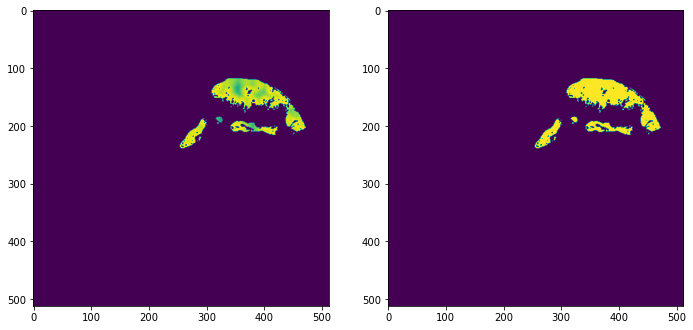

In [42]:
lbl = y_train[ind]
figure = plt.figure(figsize=(18, 18))
ax = figure.add_subplot(1, 3, 1)
ax.imshow(weight_map(lbl))
ax= figure.add_subplot(1, 3, 2)
ax.imshow(lbl)

# Train test split

In [17]:
len(x_train)

2460

In [18]:
del x_train_p

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, shuffle=True)

In [20]:
len(y_val)

615

## Fit

In [22]:
historia = model.fit(x_train, y_train,
                    batch_size = 1,
                    validation_data = (x_val, y_val),
                    epochs = 50,
                    callbacks = [model_checkpoint, reduce_plato, csvlogger],
                    shuffle = True,
                    verbose = 1)

Epoch 1/50
1845/1845 [==============================] - ETA: 0s - loss: 0.0589 - dice: 0.1531 - f1_m: 0.4391 - precision_m: 0.4338 - recall_m: 0.6068 - iou: 0.0900 - jaccard_coef: 0.0900WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_test_batch_end` time: 0.0446s). Check your callbacks.

Epoch 00001: val_dice improved from -inf to 0.19413, saving model to my_check1.h5
1845/1845 [==============================] - 367s 199ms/step - loss: 0.0589 - dice: 0.1531 - f1_m: 0.4391 - precision_m: 0.4338 - recall_m: 0.6068 - iou: 0.0900 - jaccard_coef: 0.0900 - val_loss: 0.0575 - val_dice: 0.1941 - val_f1_m: 0.3823 - val_precision_m: 0.5289 - val_recall_m: 0.4465 - val_iou: 0.1191 - val_jaccard_coef: 0.1191
Epoch 2/50
1845/1845 [==============================] - ETA: 0s - loss: 0.0257 - dice: 0.3138 - f1_m: 0.5358 - precision_m: 0.4963 - recall_m: 0.7467 - iou: 0.2030 - jaccard_coef: 0.2030  - ETA: 1:33 - loss: 0.0273 - dice: 

1845/1845 [==============================] - ETA: 0s - loss: 0.0107 - dice: 0.5943 - f1_m: 0.6794 - precision_m: 0.6130 - recall_m: 0.8402 - iou: 0.4503 - jaccard_coef: 0.4503
Epoch 00011: val_dice improved from 0.49522 to 0.50095, saving model to my_check1.h5
1845/1845 [==============================] - 367s 199ms/step - loss: 0.0107 - dice: 0.5943 - f1_m: 0.6794 - precision_m: 0.6130 - recall_m: 0.8402 - iou: 0.4503 - jaccard_coef: 0.4503 - val_loss: 0.0296 - val_dice: 0.5009 - val_f1_m: 0.5654 - val_precision_m: 0.6352 - val_recall_m: 0.6137 - val_iou: 0.3708 - val_jaccard_coef: 0.3708
Epoch 12/50
1845/1845 [==============================] - ETA: 0s - loss: 0.0104 - dice: 0.6034 - f1_m: 0.6885 - precision_m: 0.6206 - recall_m: 0.8456 - iou: 0.4592 - jaccard_coef: 0.4592
Epoch 00012: val_dice improved from 0.50095 to 0.50142, saving model to my_check1.h5
1845/1845 [==============================] - 367s 199ms/step - loss: 0.0104 - dice: 0.6034 - f1_m: 0.6885 - precision_m: 0.6206 - r

KeyboardInterrupt: 

# Fit using weight maps !!!!!!!!!!!

In [43]:
def weighted_binary_crossentropy_map(y_true, y_pred):
    zero_weight = 1
    one_weight = 4
    b_ce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce
    w_map = y_true[0].numpy()
    w_map = np.array(w_map)
    w_map = 1 + weight_map(w_map)
    
    weighted_b_ce *= w_map
    return K.mean(weighted_b_ce)

In [48]:
opt = Adam(1e-4)
model_checkpoint = ModelCheckpoint('my_check1.h5', monitor='val_dice', save_best_only=True, 
                                                                                           verbose=1, mode='max')
reduce_plato = ReduceLROnPlateau(monitor='val_loss', factor=0.094, patience=6, verbose=1, mode='max', cooldown=2)
csvlogger = CSVLogger("my_log1", append=True)
model = new_net(512,wide=True)
model.compile(run_eagerly = True,optimizer = opt, loss = weighted_binary_crossentropy_map, metrics = [dice, f1_m, precision_m, recall_m,iou,jaccard_coef])

In [49]:
historia = model.fit(x_train, y_train,
                    batch_size = 1,
                    validation_data = (x_val, y_val),
                    epochs = 50,
                    callbacks = [model_checkpoint, reduce_plato, csvlogger],
                    shuffle = True,
                    verbose = 1)

Epoch 1/50
 128/1845 [=>............................] - ETA: 9:17 - loss: 0.3639 - dice: 0.0143 - f1_m: 0.0350 - precision_m: 0.0353 - recall_m: 0.1362 - iou: 0.0073 - jaccard_coef: 0.0073

KeyboardInterrupt: 

# Сабмит


398



219777.84
197038
60


0
1
2
3
4
5
6
7
8
9



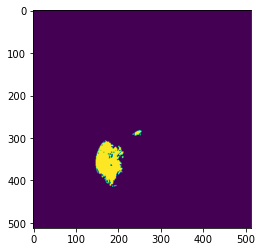

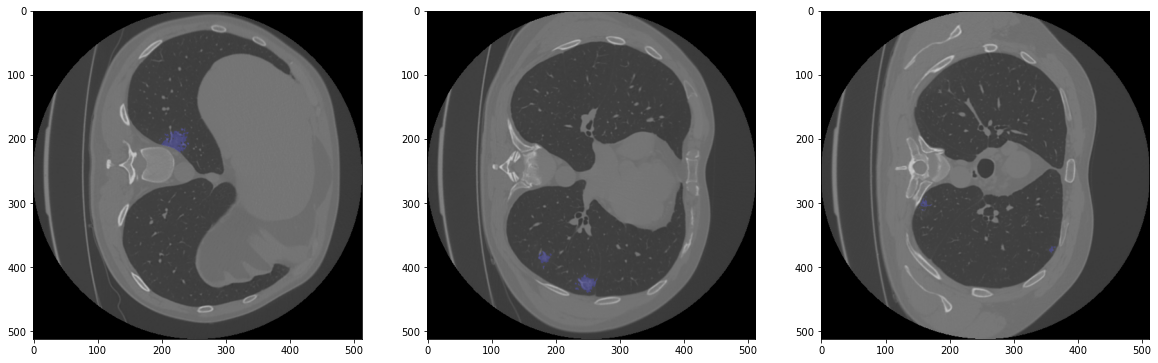

In [53]:
with open('testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_testig = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path_images, entry['image']))
    images_testig.append(image.get_fdata())
test = to_np_line(images_testig)
test = np.array(test,dtype='float32')
test = preprocess(test)
print(len(test))
pred = []
for k in tqdm(range(len(test))):
    pred.append(model.predict(np.expand_dims(test[k],0)))
print(np.sum(pred))
pred = np.array(pred)
pred.shape = 398,512,512,1
arr = np.where(pred>0.5, 1, 0)
print(np.sum(arr))
mmax = 0
ind = 0
for i in range(len(arr)):
    if (np.sum(arr[i]) > mmax):
        ind = i
        mmax = np.sum(arr[i])
    pass

print(ind)
plt.imshow(arr[ind][:,:,0])
uki = []
for i in range(len(images_testig)):
    uki.append(images_testig[i].shape[2])
tregol = []
for i in range(len(images_testig)):
    tmp = np.zeros(shape=(512,512,uki[i]))
    tregol.append(tmp)
stun = 0
for i in range(len(images_testig)):
    for k in range(uki[i]):
        l = arr[stun][:,:]
        l.shape = 512,512
        tregol[i][:,:,k] = l
        stun = stun + 1

# Visualize some of the predictions

patient_num = 8
slices_num = (10,20,30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_testig[patient_num][..., idx],
        tregol[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(20, 20))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])
    
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open("submission.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for idx, patient in tqdm(enumerate(tregol)):
        print(idx)
        submission_writer.writerow([
                f"{idx}",
                " ".join(rle_encoding(patient))
            ])

# Далее идет код, который я не использовал в финальном варианте

## !!!!!!Пред. Модель - та которая используется в лидерборде. На всякий случай прикрепляю веса в файле amazing18.h5 Их нужно загрузить в ячейке ниже для точного воспроиведения результата scoreboard

### Скор на кегл с данными весами - 0.623

In [ ]:
inputs = Input((512,512,1))
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal' )(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal' )(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
drop3 = Dropout(0.1)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4 = Dropout(0.4)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
drop5 = Dropout(0.4)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(drop5))

merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([drop3, up7], axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

## след ячейка - подгрузка весов для теста этой модели, ее можно пропустить если надо обучать с нуля

In [ ]:
model.load_weights('amazing18.h5')

In [ ]:
model = Model(inputs, conv10)

In [ ]:
opt = Adam(1e-4)
model_checkpoint = ModelCheckpoint('scoreboard.h5', monitor='val_dice', save_best_only=True, 
                                                                                           verbose=1, mode='max')
reduce_plato = ReduceLROnPlateau(monitor='val_loss', factor=0.094, patience=5, verbose=1, mode='max', cooldown=2)

In [ ]:
model.compile(optimizer = opt, loss = weighted_binary_crossentropy, metrics = [dice, f1_m, precision_m, recall_m,iou,jaccard_coef])

In [ ]:
model.load_weights('amazing18.h5') #можно не делать, но конкретно результат из scoreboard я восставновить не смог так как менял аугментации много раз

In [ ]:
historia = model.fit(x_train, y_train,
                    batch_size = 1,
                    validation_data = (x_val, y_val),
                    epochs = 50,
                    callbacks = [model_checkpoint, reduce_plato],
                    shuffle = True,
                    verbose = 1)

### Сабмит этой модели

In [ ]:
model.load_weights('scoreboard.h5')

In [ ]:
with open('testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_testig = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path_images, entry['image']))
    images_testig.append(image.get_fdata())
test = to_np_line(images_testig)
test = np.array(test,dtype='float32')
test = preprocess(test)
print(len(test))
pred = []
for k in tqdm(range(len(test))):
    pred.append(model.predict(np.expand_dims(test[k],0)))
print(np.sum(pred))
pred = np.array(pred)
pred.shape = 398,512,512,1
arr = np.where(pred>0.54, 1, 0)
print(np.sum(arr))
mmax = 0
ind = 0
for i in range(len(arr)):
    if (np.sum(arr[i]) > mmax):
        ind = i
        mmax = np.sum(arr[i])
    pass

print(ind)
plt.imshow(arr[ind][:,:,0])
uki = []
for i in range(len(images_testig)):
    uki.append(images_testig[i].shape[2])
tregol = []
for i in range(len(images_testig)):
    tmp = np.zeros(shape=(512,512,uki[i]))
    tregol.append(tmp)
stun = 0
for i in range(len(images_testig)):
    for k in range(uki[i]):
        l = arr[stun][:,:]
        l.shape = 512,512
        tregol[i][:,:,k] = l
        stun = stun + 1

# Visualize some of the predictions

patient_num = 8
slices_num = (10,20,30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_testig[patient_num][..., idx],
        tregol[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(20, 20))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])
    
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open("submission153.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for idx, patient in tqdm(enumerate(tregol)):
        print(idx)
        submission_writer.writerow([
                f"{idx}",
                " ".join(rle_encoding(patient))
            ])

  # Далее остальной код, другие модели и аугментации


#### TODO: привести в порядок эту часть

In [ ]:
len(x_train)

In [ ]:
len(y_val)

In [ ]:
x_train = preprocess(x_train)

In [ ]:
x_val = preprocess(x_val)

In [ ]:
slices = []
idp = 720
for idx in slices_num:
    slices.append(blend(
        x_train[idp],
        y_train[idp]
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [ ]:


shift = 0.1
datagen3 = ImageDataGenerator(width_shift_range= [1.2])

In [ ]:
x_train[9].shape

In [ ]:
def rot2(im):
    return cv2.rotate(im, cv2.ROTATE_180)

In [ ]:
def rot3(im):
    return cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)

In [ ]:
def comp1(im):
    return zoom_in(rot1(im))

In [ ]:
datagen4 = ImageDataGenerator(zoom_range=[0.95,0.95])

In [ ]:
def zoom_in2(im):
    f1 = np.expand_dims(im,0)
    f1 = np.expand_dims(f1,3)
    a = datagen4.flow(f1)
    kk = next(a)
    kk.shape = 512,512
    return kk

In [ ]:
def shift(im):
    return cv2.rotate(im, 45)


In [ ]:
def comp2(im):
    return flip(zoom_in(im),0)

In [ ]:
datagen2 = ImageDataGenerator(brightness_range=(0.8,0.8))

In [ ]:
def b_inc(img):
    f1 = np.expand_dims(img,0)
    f1 = np.expand_dims(f1,3)
    a = datagen2.flow(f1)
    kk = next(a)
    kk.shape = 512,512
    return kk

In [ ]:
def comp3(im):
    return b_inc(rot1(im))

In [ ]:
def comp4(im):
    return zoom_in(b_inc(flip1(rot1(im))))

In [ ]:
def comp5(im):
    return zoom_in(b_inc(flip2(rot2(im))))

In [ ]:
def comp8(im):
    return flip2(rot1(im))

In [ ]:
def comp9(im):
    return flip1(rot2(b_inc(im)))

In [ ]:
plt.imshow(comp9(x_train[71]))

In [ ]:
plt.imshow(x_train[71])

In [ ]:
x_train = np.array(x_train,dtype='float32')
y_train = np.array(y_train,dtype='float32')

In [ ]:
x_train = preprocess(x_train)

In [ ]:
x_train.shape

In [ ]:
x_aug = []
y_aug = []
for z in tqdm(range(len(x_train))):
    img = x_train[z]
    lbl = y_train[z]
    p = np.array([img,lbl])
    p = p.transpose( [1,2,0])
    im_merge_t = elastic_transform(p, p.shape[1] * 2, p.shape[1] * 0.08, p.shape[1] * 0.08)
    x_aug.append(im_merge_t[:,:,0])
    y_aug.append(im_merge_t[:,:,1])

In [ ]:
x_aug = np.array(x_aug,dtype='float32')

In [ ]:
y_aug = np.array(y_aug,dtype='float32')

In [ ]:
x_aug *= 255

In [ ]:
y_aug *= 255

In [ ]:
np.max(x_aug)

In [ ]:
x_train =np.concatenate((x_train, x_aug), axis=0)

In [ ]:
y_train =np.concatenate((y_train, y_aug), axis=0)

In [ ]:
x_train = preprocess(x_train)

In [ ]:
len(x_train)

In [ ]:
plt.imshow(y_aug[600])

In [ ]:
len(new_x)

In [ ]:
len(a)

In [ ]:
new_x = a
new_y = b
del a
del b

In [ ]:
len(new_x)

In [ ]:
x_train = np.array(new_x)
y_train = np.array(new_y)

In [ ]:
for i in range(len(x_train)):
    x_train[i] = rot3(x_train[i])
    y_train[i] = rot3(y_train[i])

In [ ]:
del new_x
del new_y

In [ ]:
len(x_train)

In [ ]:
def selff(im):
    return im

flip1 flip2 rot1 rot2 rot3 zoom_in b_inc comp1 comp2 comp3 comp4

In [ ]:
func = selff

In [ ]:
all_files_loc = "npy/"

all_files = os.listdir(all_files_loc)

maxim = -1
for i in all_files:
    if int(i.split('_')[2].split('.')[0]) > maxim:
        maxim = int(i.split('_')[2].split('.')[0])
print(maxim + 1)
new_ind = maxim + 1



for i in tqdm(range(len(x_train))):
    np.save('npy/image_file_' + str(i + new_ind)+ '.npy', func(x_aug[i]))
    np.save('npy/label_file_' + str(i + new_ind)+ '.npy', func(y_aug[i]))

In [ ]:
new_x = []
new_y = []
for i in range(len(x_train)):
    if (np.sum(y_train[i]) > 0):
        new_x.append(x_train[i])
        new_y.append(y_train[i])

In [ ]:
new_x = new_x[300:651]
new_y = new_y[300:651]

In [ ]:
x_train = np.array(new_x)
y_train = np.array(new_y)

In [ ]:
del new_x
del new_y

In [ ]:
len(x_train)

In [ ]:
ne 

In [ ]:
func_list = [flip1,rot1,rot3]

In [ ]:
func_list = [zoom_in]

### generate augs

In [ ]:
all_files_loc = "npy/"



for t in func_list:
    print(t)
    all_files = os.listdir(all_files_loc)
    maxim = -1
    for i in all_files:
        if int(i.split('_')[2].split('.')[0]) > maxim:
            maxim = int(i.split('_')[2].split('.')[0])
    print(maxim + 1)
    new_ind = maxim + 1

    for i in tqdm(range(len(x_train))):
        np.save('npy/image_file_' + str(i + new_ind)+ '.npy', t(x_train[i]))
        np.save('npy/label_file_' + str(i + new_ind)+ '.npy', t(y_train[i]))

In [ ]:
all_files = os.listdir(all_files_loc)

In [ ]:
  from keras.layers import (
        BatchNormalization,
        Conv2D,
        Conv2DTranspose,
        MaxPooling2D,
        Dropout,
        SpatialDropout2D,
        UpSampling2D,
        Input,
        concatenate,
        multiply,
        add,
        Activation,
    )

def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=64,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",  # 'deconv' or 'simple'
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=4,
    output_activation="sigmoid",
):  # 'sigmoid' or 'softmax'

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    x = inputs

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    outputs = Conv2D(num_classes, (1, 1), activation=output_activation)(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

    
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)


def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y


def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
 from tensorflow.keras.layers import (
        BatchNormalization,
        Conv2D,
        Conv2DTranspose,
        MaxPooling2D,
        Dropout,
        SpatialDropout2D,
        UpSampling2D,
        Input)
model2 = custom_unet((512,512,1),filters = 64, use_attention=True)

In [ ]:
#was 64

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def weighted_binary_crossentropy(y_true, y_pred):
    zero_weight=1
    one_weight=4
    b_ce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce
    return K.mean(weighted_b_ce)

In [ ]:
model2.summary()

In [ ]:
model3.compile(optimizer = Adam(lr=1e-4), loss=weighted_binary_crossentropy, metrics=[dice_coef,iou,jaccard_coef])

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('rewiev.h5', save_best_only=True, monitor='val_dice_coef')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')
hst = model3.fit(x_train,y_train, shuffle=True, batch_size=1,
                           epochs=20 , validation_data = (x_val,y_val),callbacks=[mcp_save, reduce_lr_loss] )

In [ ]:
model2.load_weights('pop_smoke.h5')

In [ ]:
model2.fit(training_generator,validation_data=validation_generator, shuffle=True,batch_size=1, epochs=50)

In [ ]:
model2.save_weights("pop_smoke3.h5")

In [ ]:
K.set_value(model2.optimizer.learning_rate, 3e-5)

In [ ]:
model2.fit(training_generator,validation_data=validation_generator, shuffle=True,batch_size=1, epochs=150)

In [ ]:
all_files_loc = "npy/"

all_files = os.listdir(all_files_loc)

i_files = []
l_files = []

for i in all_files:
    if (i.split('_')[0] == 'image'):
        i_files.append(int(i.split('_')[2].split('.')[0]))
        
for i in all_files:
    if (i.split('_')[0] == 'label'):
        l_files.append(int(i.split('_')[2].split('.')[0]))

In [ ]:
print(len(i_files))
print(len(l_files))

In [ ]:
val_split = 0.2

col = np.round(len(i_files) * val_split).astype('int')
print(col)

In [ ]:
valid = np.random.choice(i_files,col)
print(len(valid))

In [ ]:
print(len(valid))

In [ ]:
train = [i for i in i_files if i not in valid]
print(len(train))

In [ ]:
valid_all_files = []
for i in valid:
    valid_all_files.append('image_file_' + str(i)+'.npy')
    valid_all_files.append('label_file_' + str(i)+'.npy')

In [ ]:
train_all_files = []
for i in train:
    train_all_files.append('image_file_' + str(i)+'.npy')
    train_all_files.append('label_file_' + str(i)+'.npy')

In [ ]:
len(train_all_files)

In [ ]:
valid_all_files

In [ ]:
for i in tqdm(train):
    print(i)
    a = np.load('npy/image_file_' + str(i)+ '.npy')
    np.save('trn/image_file_' + str(i)+ '.npy',a)
    a = np.load('npy/label_file_' + str(i)+ '.npy')
    np.save('trn/label_file_' + str(i)+ '.npy',a)

In [ ]:
for i in tqdm(valid):
    print(i)
    a = np.load('npy/image_file_' + str(i)+ '.npy')
    np.save('val/image_file_' + str(i)+ '.npy',a)
    a = np.load('npy/label_file_' + str(i)+ '.npy')
    np.save('val/label_file_' + str(i)+ '.npy',a)

In [ ]:
import random
class DataGenerator(keras.utils.Sequence):

    def __init__(self, file_list,data_loc,batchsize):
        """Constructor can be expanded,
           with batch size, dimentation etc.
        """
        self.path = data_loc
        self.file_list = file_list
        self.on_epoch_end()
        self.batch_size = batchsize

    def __len__(self):
        'Take all batches in each iteration'
        return int(len(self.file_list) // self.batch_size)

    def __getitem__(self, index):
        'Get next batch'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index + 1) *self.batch_size]
        # single file
        file_list_temp = [self.file_list[k] for k in indexes]
        # Set of X_train and y_train
        X, y = self.__data_generation(file_list_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        self.indexes = sorted(self.indexes, key=lambda A: random.random())
        self.indexes = np.array(self.indexes)

    def __data_generation(self, file_list_temp):
        'Generates data containing batch_size samples'
        data_loc = self.path
        # Generate data
        all_x = []
        all_y = []
        for ID in file_list_temp:
            x_file_path = os.path.join(data_loc, ID)
            y_file_path = os.path.join(data_loc, 'label_file_'+ID.split('_')[2])

            # Store sample
            X_t = np.load(x_file_path)
            # Store class
            y_t = np.load(y_file_path)
            all_x.append(X_t)
            all_y.append(y_t)
        return np.array(all_x), np.array(all_y)

In [ ]:
partition1 = [item for item in train_all_files if "image_file" in item]
partition2 = [item for item in valid_all_files if "image_file" in item]

training_generator = DataGenerator(partition1,'npy/',1)
validation_generator = DataGenerator(partition2,'npy/',1)

In [ ]:
training_generator.__getitem__(0)[1].shape

In [ ]:
len(new_x)

In [ ]:
x_train = np.array(new_x)
y_train = np.array(new_y)

In [ ]:
plt.imshow(y_train[3])

In [ ]:
plt.imshow(x_train[3])

In [ ]:
x_train_p = preprocess(x_train)
del x_train

In [ ]:
del x_train
del y_train

In [ ]:
all_files_loc = "val/"

all_files = os.listdir(all_files_loc)

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)/2))}


partition = [item for item in all_files if "image_file" in item]

class DataGenerator2(keras.utils.Sequence):

    def __init__(self, file_list):

        self.file_list = file_list
        self.on_epoch_end()
        self.batch_size = 2

    def __len__(self):
        'Take all batches in each iteration'
        return int(len(self.file_list))

    def __getitem__(self, index):
        'Get next batch'
        # Generate indexes of the batch
        indexes = self.indexes[index:(index+1)]

        # single file
        file_list_temp = [self.file_list[k] for k in indexes]

        # Set of X_train and y_train
        X, y = self.__data_generation(file_list_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.file_list))
        self.indexes = sorted(self.indexes, key=lambda A: random.random())
        self.indexes = np.array(self.indexes)

    def __data_generation(self, file_list_temp):
        'Generates data containing batch_size samples'
        data_loc = "val/"
        # Generate data
        all_x = []
        all_y = []
        for ID in file_list_temp:
            x_file_path = os.path.join(data_loc, ID)
            y_file_path = os.path.join(data_loc, 'label_file_'+ID.split('_')[2])

            # Store sample
            X_t = np.load(x_file_path)
            # Store class
            y_t = np.load(y_file_path)
            all_x.append(X_t)
            all_y.append(y_t)
        return np.array(all_x), np.array(all_y)

    
# ====================
# train set
# ====================
all_files_loc = "val/"
all_files = os.listdir(all_files_loc)

validation_generator = DataGenerator2(partition)
validation_generator.__getitem__(0)[1].shape

# NEW MODEL

In [ ]:

from keras.models import Model
from keras.layers import Input
from keras.layers.core import Lambda, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def weighted_binary_crossentropy(y_true, y_pred):#ponderacion de pesos para darle mayor peso a la clase=1
    zero_weight=1
    one_weight=4
    b_ce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce
    return K.mean(weighted_b_ce)

In [ ]:
import tensorflow

In [ ]:
inputs = Input((512,512,1))
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal' )(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal' )(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
drop3 = Dropout(0.1)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4 = Dropout(0.4)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
drop5 = Dropout(0.4)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(drop5))

merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([drop3, up7], axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)


loss_function = weighted_binary_crossentropy

model = Model(inputs, conv10)

o = Adam(lr = 1e-4)    

model.compile(o, loss=loss_function, metrics=[dice_loss], run_eagerly=True)
# model.summary()

In [ ]:
from keras.layers.core import Lambda, Activation
def fcn_8s(num_classes, input_shape, lr_init, lr_decay, vgg_weight_path=None):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D()(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D()(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    block_3_out = MaxPooling2D()(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(block_3_out)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    block_4_out = MaxPooling2D()(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(block_4_out)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(img_input, x)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # Convolutinalized fully connected layer.
    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Classifying layers.
    x = Conv2D(num_classes, (1, 1), strides=(1, 1), activation='linear')(x)
    x = BatchNormalization()(x)

    block_3_out = Conv2D(num_classes, (1, 1), strides=(1, 1), activation='linear')(block_3_out)
    block_3_out = BatchNormalization()(block_3_out)

    block_4_out = Conv2D(num_classes, (1, 1), strides=(1, 1), activation='linear')(block_4_out)
    block_4_out = BatchNormalization()(block_4_out)

    # Adding layers
    x = Lambda(lambda x: tf.image.resize(x, (x.shape[1] * 2, x.shape[2] * 2)))(x)
    x = Add()([x, block_4_out])
    x = Activation('relu')(x)

    x = Lambda(lambda x: tf.image.resize(x, (x.shape[1] * 2, x.shape[2] * 2)))(x)
    x = Add()([x, block_3_out])
    x = Activation('relu')(x)

    x = Lambda(lambda x: tf.image.resize(x, (x.shape[1] * 8, x.shape[2] * 8)))(x)
    x = Activation('softmax')(x)
    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
model3 = fcn_8s(input_shape=(512,512,1),
                       num_classes=1,
                       lr_init=1e-2,
                       lr_decay=0.1)

In [ ]:
model3.summary()

In [ ]:
model.load_weights('amazing18.h5')

In [ ]:
model.output

In [ ]:
from keras.layers import Input, Activation, UpSampling2D, LeakyReLU, Multiply, Add, Average, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, Conv3D, MaxPooling3D, Dropout, BatchNormalization, concatenate

In [ ]:
model = att_net(512, wide = True)

In [ ]:
model.compile(optimizer = Adam(), loss=weighted_binary_crossentropy, metrics=[dice_loss])

In [ ]:
model.load_weights('ti.h5')

# learn

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:

hst = model.fit(training_generator, shuffle=True, 
                           epochs=6 , validation_data = validation_generator)

In [ ]:
model.save_weights('hhh1.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('try_sec.h5', save_best_only=True, monitor='val_dice_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')
hst = model.fit(training_generator, shuffle=True, 
                           epochs=6 , validation_data = validation_generator,callbacks=[mcp_save, reduce_lr_loss] )

In [ ]:
model.save_weights('hhh2.h5')

In [ ]:
!!!!

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('MMM.h5', save_best_only=True, monitor='val_dice_loss')
hst = model.fit(training_generator, shuffle=True, 
                           epochs=50 , validation_data = validation_generator,callbacks=[mcp_save] )

In [ ]:
model.save_weights('hhh3.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('try_sec.h5', save_best_only=True, monitor='val_dice_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')
hst = model.fit(training_generator, shuffle=True, 
                           epochs=6 , validation_data = validation_generator,callbacks=[mcp_save, reduce_lr_loss] )

In [ ]:
model.save_weights('hhh4.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('try_sec.h5', save_best_only=True, monitor='val_dice_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')
hst = model.fit(training_generator, shuffle=True, 
                           epochs=6 , validation_data = validation_generator,callbacks=[mcp_save, reduce_lr_loss] )

In [ ]:
model.save_weights('hhh5.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('try_sec.h5', save_best_only=True, monitor='val_dice_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')
hst = model.fit(training_generator, shuffle=True, 
                           epochs=6 , validation_data = validation_generator,callbacks=[mcp_save, reduce_lr_loss] )

In [ ]:
model.save_weights('hhh6.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('try_sec.h5', save_best_only=True, monitor='val_dice_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')
hst = model.fit(training_generator, shuffle=True, 
                           epochs=6 , validation_data = validation_generator,callbacks=[mcp_save, reduce_lr_loss] )

In [ ]:
model.save_weights('hhh7.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('try_sec.h5', save_best_only=True, monitor='val_dice_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')
hst = model.fit(training_generator, shuffle=True, 
                           epochs=6 , validation_data = validation_generator,callbacks=[mcp_save, reduce_lr_loss] )

In [ ]:
model.save_weights('hhh8.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('try_sec.h5', save_best_only=True, monitor='val_dice_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')
hst = model.fit(training_generator, shuffle=True, 
                           epochs=6 , validation_data = validation_generator,callbacks=[mcp_save, reduce_lr_loss] )

# Additive

In [ ]:
pred = []
for k in tqdm(range(len(x_train))):
    pred.append(soa_model.predict(np.expand_dims(x_train[k],0)))
print(np.sum(pred))

In [ ]:
pred = np.array(pred,dtype='float32')

In [ ]:
pred[0].shape

In [ ]:
inp = []
for i in tqdm(range(len(pred))):
    a = pred[i]
    a.shape = 512,512
    inp.append(np.array((x_train[i], a)))

In [ ]:
inp = np.array(inp,dtype = 'float32')
inp.shape

In [ ]:
inp = inp.transpose(0, 2, 3,1)

In [ ]:
inp.shape

In [ ]:
inputs = Input((512,512,2))
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal' )(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal' )(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
drop3 = Dropout(0.1)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4 = Dropout(0.4)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
drop5 = Dropout(0.4)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(drop5))

merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([drop3, up7], axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)


   


loss_function = dice_loss

app_mod = Model(inputs, conv10)

In [ ]:
app_mod.summary()

In [ ]:
del x_train

In [ ]:
del pred

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [ ]:
del x_test_p

In [ ]:
del arr2
del arr3

In [ ]:
del x_test

In [ ]:
app_mod.compile(optimizer = Adam(3e-5), loss=dice_loss, metrics=[dice_loss])

In [ ]:
history = app_mod.fit(inp ,y_train,batch_size=1, epochs=100, verbose=1, shuffle=True, validation_split=0.2)

In [ ]:
app_mod.save_weights('lol.h5')

# SOA model

In [ ]:
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.optimizers import *
from keras.layers import *        
    
def BCDU_net_D3(input_size = (512,512,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=3e-2,
        decay_steps=3000,
        decay_rate=0.9)

    o = Adam(lr_schedule)   
    
#     model = Model(inputs, conv9)
#     from keras_radam.training import RAdamOptimizer
    model = Model(inputs,conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = weighted_binary_crossentropy, metrics = ['accuracy',dice_coeff])       
    return model

def BCDU_net_D1(input_size = (512,512,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
   
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv4_1)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(input = inputs, output = conv9)
    loss_function = dice_loss
    model.compile(optimizer = Adam(), loss = loss_function, metrics = [dice_loss])    
    return model

In [ ]:
soa_model = BCDU_net_D3()

In [ ]:
soa_model.load_weights('soa4.h5')

In [ ]:
soa_model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('weight_lung.h5', save_best_only=True, monitor='val_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
hst = soa_model.fit(training_generator, shuffle=True, 
                           epochs=50 , validation_data = validation_generator,callbacks=[mcp_save, reduce_lr_loss] )

In [ ]:
soa_model.save_weights('soa5.h5')

# Prediction && Submission

In [ ]:
with open('testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_testig = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path_images, entry['image']))
    images_testig.append(image.get_fdata())
test = to_np_line(images_testig)
test = np.array(test,dtype='float32')
test = preprocess(test)
print(len(test))
pred = []
for k in tqdm(range(len(test))):
    pred.append(model.predict(np.expand_dims(test[k],0)))
print(np.sum(pred))
pred = np.array(pred)
pred.shape = 398,512,512,1
arr = np.where(pred>0.54, 1, 0)
print(np.sum(arr))
mmax = 0
ind = 0
for i in range(len(arr)):
    if (np.sum(arr[i]) > mmax):
        ind = i
        mmax = np.sum(arr[i])
       
print(ind)
plt.imshow(arr[ind][:,:,0])
uki = []
for i in range(len(images_testig)):
    uki.append(images_testig[i].shape[2])
tregol = []
for i in range(len(images_testig)):
    tmp = np.zeros(shape=(512,512,uki[i]))
    tregol.append(tmp)
stun = 0
for i in range(len(images_testig)):
    for k in range(uki[i]):
        l = arr[stun][:,:]
        l.shape = 512,512
        tregol[i][:,:,k] = l
        stun = stun + 1\

# Visualize some of the predictions

patient_num = 8
slices_num = (10,20,30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_testig[patient_num][..., idx],
        tregol[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(20, 20))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])
    
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open("submission152.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for idx, patient in tqdm(enumerate(tregol)):
        print(idx)
        submission_writer.writerow([
                f"{idx}",
                " ".join(rle_encoding(patient))
            ])

In [ ]:
model.load_weights('att_netv3_checkpointv5.h5')

# 176318.0 best amazing_18

In [ ]:
pred = np.array(pred)

In [ ]:
pred.shape

In [ ]:
pred.shape = 398,512,512,1
arr = np.where(pred>0.54, 1, 0)

In [ ]:
print(np.sum(arr))

In [ ]:
mmax = 0
ind = 0
for i in range(len(arr)):
    if (np.sum(arr[i]) > mmax):
        ind = i
        mmax = np.sum(arr[i])
       
print(ind)
plt.imshow(arr[ind][:,:,0])

In [ ]:
uki = []
for i in range(len(images_testig)):
    uki.append(images_testig[i].shape[2])
tregol = []
for i in range(len(images_testig)):
    tmp = np.zeros(shape=(512,512,uki[i]))
    tregol.append(tmp)
stun = 0
for i in range(len(images_testig)):
    for k in range(uki[i]):
        l = arr[stun][:,:]
        l.shape = 512,512
        tregol[i][:,:,k] = l
        stun = stun + 1

In [ ]:
# Visualize some of the predictions

patient_num = 8
slices_num = (10,20,30)
slices = []
for idx in slices_num:
    slices.append(blend(
        images_testig[patient_num][..., idx],
        tregol[patient_num][..., idx]
    ))

figure = plt.figure(figsize=(20, 20))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [ ]:
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

with open("submission152.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for idx, patient in tqdm(enumerate(tregol)):
        print(idx)
        submission_writer.writerow([
                f"{idx}",
                " ".join(rle_encoding(patient))
            ])